Data from many different sources. This notebook makes the last plot of
the paper.

TODO: need to drop duplicates between RL & CEL regions, note that RL and CEL not consistent as labeled 
also would be nice to seperate RL by galaxy? and high z as well

# Introduction

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import vice


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [3]:
from singlezone import run_singlezone, exp_sfh

In [4]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [5]:
def plot_abund_errs(df, x="O_H", y="C_O", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [6]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [7]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [8]:
def plot_sample_err(df, df_err=None, color=COLORS[0], edgecolors=None, marker="*", label="", **kwargs):
    if edgecolors is None:
        edgecolors = color
        
    if df_err is None:
        df_err = calc_errs(df)
        
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, edgecolors=edgecolors, label=label, **kwargs)
    
    old_color = color

    if color == "none":
        color = edgecolors
        
    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)

    
    if old_color == "none":
        color = "white"
    plt.scatter(df_err["O_H"], df_err["C_O"], marker=marker, color=color, edgecolors=edgecolors, **kwargs)
    

    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [9]:
surp.set_yields(verbose=False)

In [10]:
all_stars = pd.read_csv("data_analysis/amarsi19_cleaned.csv")

In [11]:
all_star_err = pd.DataFrame()


# split into two regemes and plot error bars
mh_cut = -0.3

low_z = all_stars[all_stars["O_H"] < mh_cut]
high_z = all_stars[all_stars["O_H"] >= mh_cut]
all_star_err = pd.concat([calc_errs(low_z), calc_errs(high_z)], ignore_index=True)
all_star_err

,O_H_err,C_O_err,O_H,C_O
0,0.023074,0.060948,-1.0091,-0.5907
1,0.018365,0.031701,0.0018,-0.0034


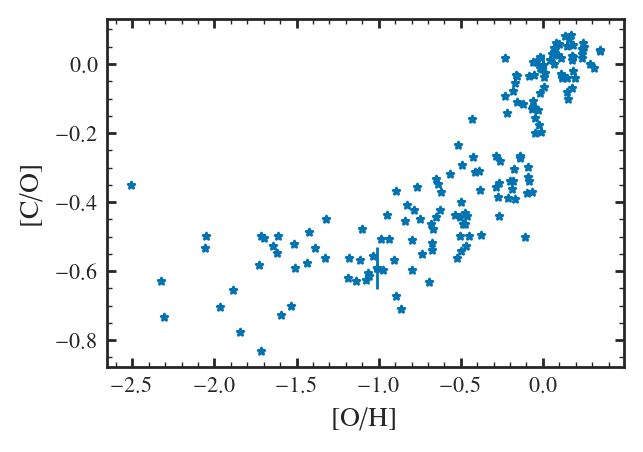

In [12]:
plot_sample_err(all_stars, all_star_err)

In [13]:
RL = pd.read_csv("data_analysis/RL_combined.csv")
RL = RL[~np.isnan(RL.C_O_err)]
RL_err = calc_errs(RL)

In [14]:
RL_mw = RL[RL.galaxy == "MW"]
RL_mw_err = calc_errs(RL_mw)

RL = RL[RL.galaxy != "MW"]
RL_err = calc_errs(RL)

In [15]:
np.sort(RL.galaxy.unique())

array(['LMC', 'M101', 'M31', 'M33', 'NGC 2366', 'NGC 2403', 'NGC 300',
       'NGC 5408', 'NGC 6822', 'SMC'], dtype=object)

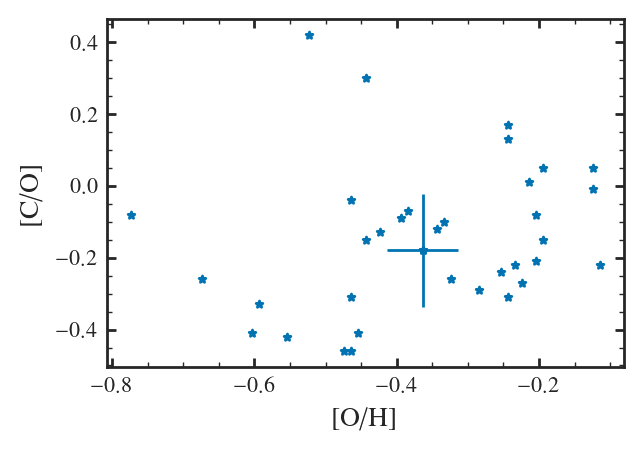

In [16]:
plot_sample_err(RL, RL_err)

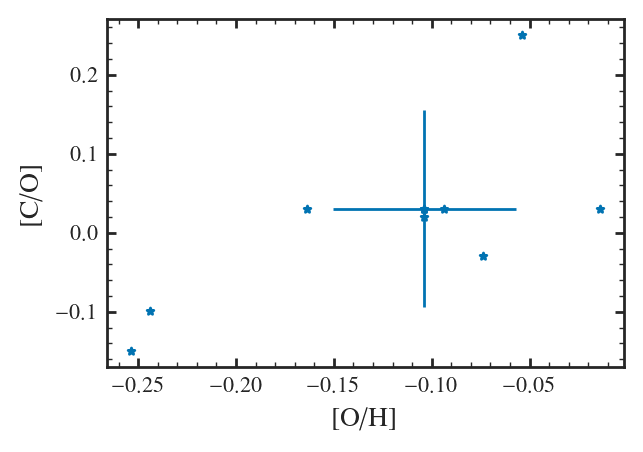

In [17]:
plot_sample_err(RL_mw, RL_mw_err)

In [18]:
DLA = pd.read_csv("data_analysis/DLA_combined.csv")
DLA = DLA[~np.isnan(DLA.C_O_err)]

DLA_err = calc_errs(DLA)

In [19]:
DLA.loc[6].log_OI

np.float64(12.06)

In [20]:
DLA.sort_values("C_O")[["galaxy", "study", "C_O", "O_H"]]

,galaxy,study,C_O,O_H
13,J0953-0504,dutta+14,-0.54963,-2.673789
2,J0955+4116,welsh+2022,-0.50963,-2.573789
11,J0311-1722,cooke+11,-0.46963,-2.413789
12,J1001+0343,cooke+11,-0.45963,-2.773789
8,Q2059-360,dessauges-zavadsky+03,-0.45963,-1.483789
16,Q0913+072,pettini+08,-0.43963,-2.523789
19,Q2206-199,pettini+08,-0.42963,-2.193789
10,J0903+2628,cooke+17,-0.42963,-3.173789
3,J0140-0839,ellison+10,-0.34963,-2.873789
9,J2155+1358,dessauges-zavadsky+03,-0.33963,-1.923789


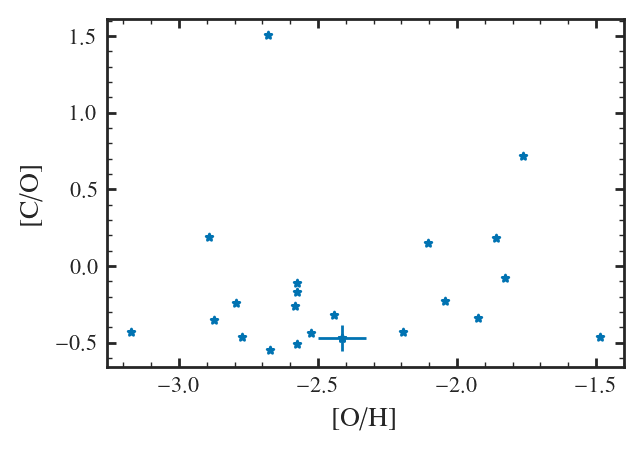

In [21]:
plot_sample_err(DLA, DLA_err)

In [22]:
CEL = pd.read_csv("data_analysis/CEL_combined.csv")
CEL_filt = ~np.isin(CEL.galaxy, RL.galaxy.unique())
CEL_filt &= ~np.isnan(CEL.C_O_err)
CEL = CEL[CEL_filt]
CEL_err = calc_errs(CEL)

In [23]:
CEL.galaxy.unique()

array(['NGC 2363', 'Tol 1214-277', 'SDSS J094401.87-003832.1',
       'SDSS J102429.25+052450.9', 'UGC 5189', 'Mrk 193',
       'SDSS J094252.78+354726.0', 'LEDA 41360', 'IC 700', 'LEDA 36857',
       'NGC 4204', 'NGC 4301', 'I Zw 18', 'SBS 0335-052', 'UM 469',
       'NGC 4861', 'Tol 1345-420', 'NGC 5253', 'J082555', 'J104457',
       'J120122', 'J124159', 'J122622', 'J122436', 'J124827', 'J223831',
       'J141851', 'J120202', 'J121402', 'J084236', 'J171236', 'J113116',
       'J133126', 'J132853', 'J095430', 'J132347', 'J094718', 'J150934',
       'J100348', 'J025346', 'J015809', 'J104654', 'J093006', 'J092055',
       'Mrk 960', 'SBS 0218+003', 'Mrk 1087', 'NGC 1087', 'Mrk 5',
       'Mrk 1199', 'IRAS 08208+2816', 'IRAS 08339+6517', 'SBS 0926+606A',
       'ARP 252', 'SBS 0948+532', 'Tol 9', 'SBS 1054+365', 'POX 4',
       'SBS 1319+579', 'SBS 1415+437', 'Tol 1457-262', 'III Zw 107'],
      dtype=object)

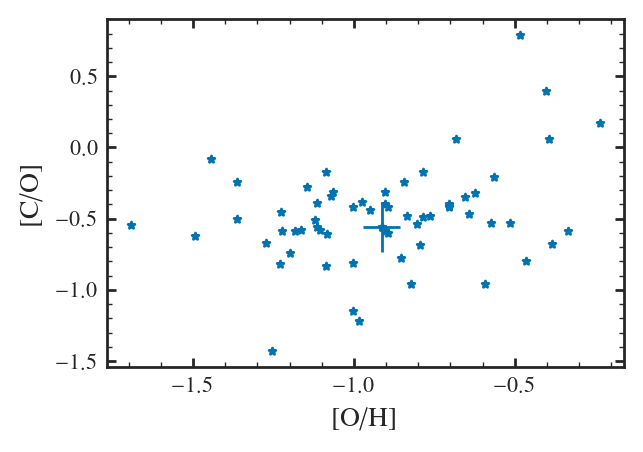

In [24]:
plot_sample_err(CEL, CEL_err)

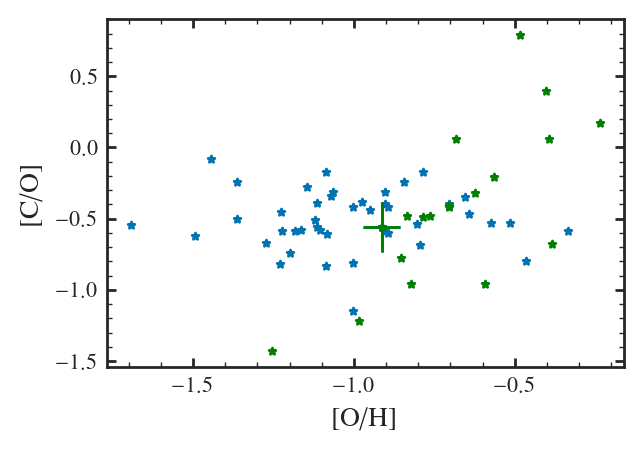

In [25]:
plot_sample_err(CEL[CEL.study != "pena-guerreno+17"], CEL_err)
plot_sample_err(CEL[CEL.study == "pena-guerreno+17"], CEL_err, color="green")

In [26]:
CEL.sort_values("C_O")[["region", "galaxy", "O_H", "C_O", "study"]]

,region,galaxy,O_H,C_O,study
67,NaN,SBS 1415+437,-1.253789,-1.42963,pena-guerreno+17
68,NaN,Tol 1457-262,-0.983789,-1.21963,pena-guerreno+17
4,centre,SDSS J094401.87-003832.1,-1.003789,-1.14963,senchyna+17
69,NaN,III Zw 107,-0.593789,-0.95963,pena-guerreno+17
53,NaN,SBS 0218+003,-0.823789,-0.95963,pena-guerreno+17
...,...,...,...,...,...
59,NaN,IRAS 08339+6517,-0.393789,0.06037,pena-guerreno+17
61,NaN,ARP 252,-0.683789,0.06037,pena-guerreno+17
63,NaN,Tol 9,-0.233789,0.17037,pena-guerreno+17
54,NaN,Mrk 1087,-0.403789,0.40037,pena-guerreno+17


In [27]:
high_z = pd.read_csv("data_analysis/high_z_cleaned.csv")
high_z = high_z[~np.isnan(high_z.C_O_err)]

high_z_err = calc_errs(high_z)

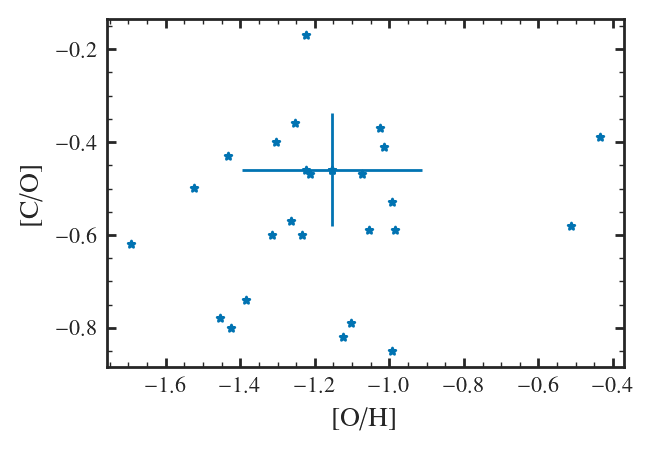

In [28]:
plot_sample_err(high_z, high_z_err)

# Fiducial model

In [29]:
subgiants_ha = subgiants[subgiants.high_alpha]

fiducial = ViceModel.from_file("../models/fiducial/run/model.json")

In [30]:
h_today = fiducial.history[fiducial.history.time == np.max(fiducial.history.time)]
h_today = h_today[(h_today.R > 1) & (h_today.R < 15.5)].sort_values("R")
h_today

,time,mgas,mstar,sfr,ifr,ofr,eta_0,r_eff,z_in(fe),z_in(o),...,N_MG,C_FE,C_O,C_MG,C_N,z,M_H,lookback,R,zone
5948,13.2,59273000.0,659179900.0,0.028630,0.002500,0.000000,0.000000,0.602311,0.0,0.0,...,0.166163,-0.017927,0.015838,0.016299,-0.149864,0.050223,0.455393,0.0,1.05,10
57506,13.2,62814390.0,691499100.0,0.030341,0.004460,0.000000,0.000000,0.585485,0.0,0.0,...,0.155364,-0.013142,0.010847,0.011308,-0.144056,0.049213,0.446567,0.0,1.15,11
64116,13.2,66056070.0,653891100.0,0.031907,0.002011,0.000000,0.000000,0.630016,0.0,0.0,...,0.147918,-0.002281,0.016515,0.016975,-0.130943,0.048227,0.437776,0.0,1.25,12
16524,13.2,69012350.0,679992500.0,0.033335,0.008689,0.000000,0.000000,0.493804,0.0,0.0,...,0.135169,-0.003645,0.008182,0.008642,-0.126527,0.046398,0.420985,0.0,1.35,13
1321,13.2,71697090.0,679107700.0,0.034631,0.005712,0.000000,0.000000,0.545327,0.0,0.0,...,0.146929,-0.002868,0.006684,0.007144,-0.139785,0.047110,0.427604,0.0,1.45,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102454,13.2,76332940.0,29212920.0,0.003485,0.013945,0.011862,3.403922,0.433321,0.0,0.0,...,-0.234293,-0.003304,-0.088240,-0.087779,0.146514,0.003528,-0.697970,0.0,15.05,150
74692,13.2,75844630.0,31133080.0,0.003347,0.013731,0.011674,3.487762,0.422002,0.0,0.0,...,-0.236024,-0.002160,-0.088508,-0.088047,0.147977,0.003446,-0.708191,0.0,15.15,151
113691,13.2,75345540.0,28446870.0,0.003213,0.013395,0.011482,3.573357,0.432297,0.0,0.0,...,-0.238678,0.001629,-0.085080,-0.084619,0.154059,0.003371,-0.717760,0.0,15.25,152
15202,13.2,74834630.0,28168240.0,0.003083,0.013195,0.011284,3.660745,0.419564,0.0,0.0,...,-0.242071,0.006411,-0.087918,-0.087457,0.154614,0.003282,-0.729415,0.0,15.35,153


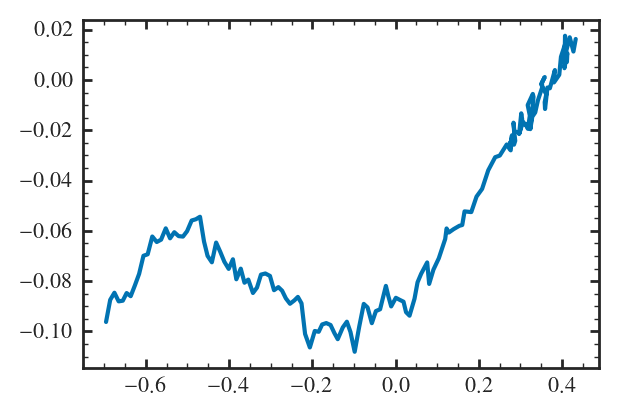

In [31]:
def plot_fiducial():
    plt.plot(h_today.MG_H, h_today.C_MG, label="Model (present day)", zorder=9, lw=1.5, color=arya.style.COLORS[0])
    
plot_fiducial()

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

# Singlezone models

## TODO: pull these somehow from the singlezone notebook

In [32]:
yp = surp.YieldParams.from_file("../models/analytic/mc_best/yield_params.toml")
surp.set_yields(yp)

sz_fiducial = run_singlezone()[1]

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: C

change dwarf parameters to
match Wukong from James’ dwarf paper. 𝜂 = 47.99 ± 5, 𝑡end = 3.36 ± 0.5,
𝜏★ = 44.97 ± 7, 𝜏sfh = 3.08 ± 1

In [33]:
48 * 0.6

28.799999999999997

In [34]:
yp_lowz = surp.YieldParams.from_file("../models/analytic/linear/yield_params.toml")

surp.set_yields(yp_lowz)

y_scale = 0.6# 0.712

sz_models = [
    run_singlezone(verbose=True)[1],
    run_singlezone(eta=y_scale * 9.56, t_end=10.73, tau_star=26.60, tau_sfh=2.18, sfh=exp_sfh(None), mode="ifr", verbose=True)[1], # GSE
    run_singlezone(eta=y_scale * 48, t_end=3.4, tau_star=45, tau_sfh=3.08, sfh=exp_sfh(None), mode="ifr", verbose=True)[1], # wukong
]

vice.singlezone{
    name -----------> onezonemodel
    func -----------> sfh ∝ (1-exp(t/2.0) * exp(-t/14)
    mode -----------> sfr
    verbose --------> False
    elements -------> ('c', 'n', 'mg', 'fe')
    IMF ------------> kroupa
    eta ------------> 0.5
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.15
    RIa ------------> plaw
    Mg0 ------------> 1.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 2.5
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.0176
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: C

vice.singlezone{
    name -----------> onezonemodel
    func -----------> sfh ∝ exp(-t/2.18)
    mode -----------> ifr
    verbose --------> False
    elements -------> ('c', 'n', 'mg', 'fe')
    IMF ------------> kroupa
    eta ------------> 5.736
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.15
    RIa ------------> plaw
    Mg0 ------------> 1.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 26.6
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.0176
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/outputs/output.py:131: UserWarning: agb mg yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was 

vice.singlezone{
    name -----------> onezonemodel
    func -----------> sfh ∝ exp(-t/3.08)
    mode -----------> ifr
    verbose --------> False
    elements -------> ('c', 'n', 'mg', 'fe')
    IMF ------------> kroupa
    eta ------------> 28.799999999999997
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.15
    RIa ------------> plaw
    Mg0 ------------> 1.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 45.0
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.0176
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: fe
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/outputs/output.py:131: UserWarning: agb mg yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was 

In [35]:
from surp.yields import calc_y

In [36]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = calc_y(Z)
y_agb = calc_y(Z, kind="agb")
y_cc = calc_y(Z, kind="cc")
y_ia = calc_y(Z, kind="ia")

yo = calc_y(ele="o")

In [37]:
def plot_sz(zorder=10):
    #singlezone
    for i in range(len(sz_models)):
        out = sz_models[i]
        if i == 0:
            label="singlezone"
        else:
            label=""
        plt.plot(out.MG_H, out.C_MG, label=label, color="k", 
                 lw=1, zorder=zorder, ls=[":", "--", "-."][i])

    plt.plot(sz_fiducial.MG_H, sz_fiducial.C_MG, label=label, color="k", 
             lw=1, zorder=zorder)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [38]:
sz_models[1]

,time,mgas,mstar,sfr,ifr,ofr,eta_0,r_eff,z_in(c),z_in(n),...,C_H,C_N,N_H,C_MG,N_MG,MG_H,C_FE,N_FE,MG_FE,FE_H
0,0.00,1.0,0.000000e+00,3.759398e-11,1.000000,2.156391e-10,5.736,0.095771,0.0,0.0,...,-inf,NaN,-inf,NaN,NaN,-inf,NaN,NaN,NaN,-inf
1,0.01,10000000.0,3.399356e-04,3.759399e-04,0.995423,2.156391e-03,5.736,0.095771,0.0,0.0,...,-11.051991,-0.309046,-10.742945,-0.614635,-0.305588,-10.437357,-0.165250,0.143796,0.449385,-10.886741
2,0.02,19929270.0,3.399357e+03,7.492207e-04,0.990868,4.297530e-03,5.736,0.120187,0.0,0.0,...,-4.351467,-0.309046,-4.042421,-0.614635,-0.305589,-3.736832,-0.165250,0.143796,0.449385,-4.186217
3,0.03,29788380.0,9.991095e+03,1.119864e-03,0.986333,6.423540e-03,5.736,0.136515,0.0,0.0,...,-4.050291,-0.309046,-3.741245,-0.614635,-0.305588,-3.435657,-0.165250,0.143796,0.449384,-3.885041
4,0.04,39577800.0,1.966095e+04,1.487887e-03,0.981819,8.534522e-03,5.736,0.148749,0.0,0.0,...,-3.874052,-0.309046,-3.565005,-0.614635,-0.305589,-3.259417,-0.165250,0.143796,0.449385,-3.708801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,10.69,326097600.0,1.730708e+08,1.225931e-02,0.007419,7.031938e-02,5.736,0.533510,0.0,0.0,...,-0.678425,0.165354,-0.843779,-0.099075,-0.264429,-0.579349,-0.065702,-0.231056,0.033374,-0.612723
1070,10.70,325411400.0,1.731280e+08,1.223351e-02,0.007385,7.017141e-02,5.736,0.533757,0.0,0.0,...,-0.677784,0.165443,-0.843227,-0.098924,-0.264367,-0.578860,-0.065722,-0.231165,0.033202,-0.612062
1071,10.71,324726500.0,1.731850e+08,1.220776e-02,0.007352,7.002372e-02,5.736,0.534005,0.0,0.0,...,-0.677144,0.165531,-0.842675,-0.098773,-0.264304,-0.578371,-0.065743,-0.231274,0.033030,-0.611401
1072,10.72,324042900.0,1.732419e+08,1.218206e-02,0.007318,6.987631e-02,5.736,0.534252,0.0,0.0,...,-0.676505,0.165619,-0.842124,-0.098622,-0.264241,-0.577883,-0.065765,-0.231383,0.032858,-0.610740


Text(0, 0.5, 'sfr')

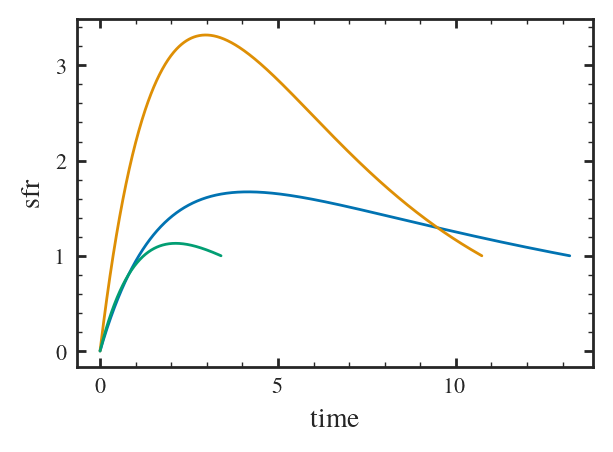

In [39]:
for model in sz_models:
    plt.plot(model.time, model.sfr / model.sfr.iloc[-1])
plt.xlabel("time")
plt.ylabel("sfr")

Text(0, 0.5, 'ifr')

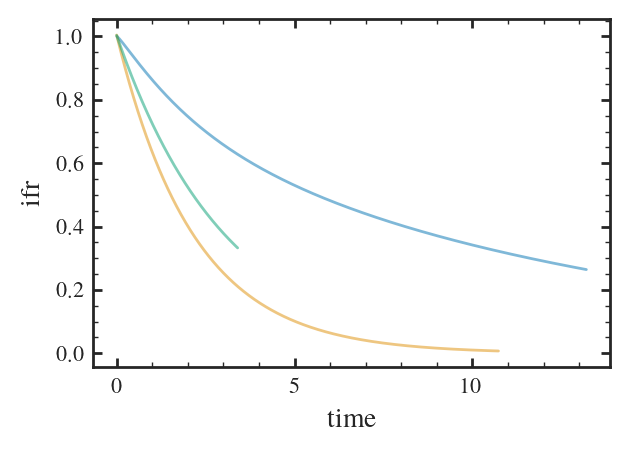

In [40]:
for model in sz_models:
    plt.plot(model.time, model.ifr / model.ifr.iloc[1], alpha=0.5)
plt.xlabel("time")
plt.ylabel("ifr")

In [61]:
type(vice.mlr.larson1974(0.1, which="age"))

float

In [74]:
?secax.set_xticks

Signature: secax.set_xticks(ticks, labels=None, *, minor=False, **kwargs)
Docstring:
Set the xaxis' tick locations and optionally tick labels.

If necessary, the view limits of the Axis are expanded so that all
given ticks are visible.

Parameters
----------
ticks : 1D array-like
    Array of tick locations (either floats or in axis units). The axis
    `.Locator` is replaced by a `~.ticker.FixedLocator`.

    Pass an empty list (``set_xticks([])``) to remove all ticks.

    Some tick formatters will not label arbitrary tick positions;
    e.g. log formatters only label decade ticks by default. In
    such a case you can set a formatter explicitly on the axis
    using `.Axis.set_major_formatter` or provide formatted
    *labels* yourself.

labels : list of str, optional
    Tick labels for each location in *ticks*; must have the same length as
    *ticks*. If set, the labels are used as is, via a `.FixedFormatter`.
    If not set, the labels are generated using the axis tick `.Formatt

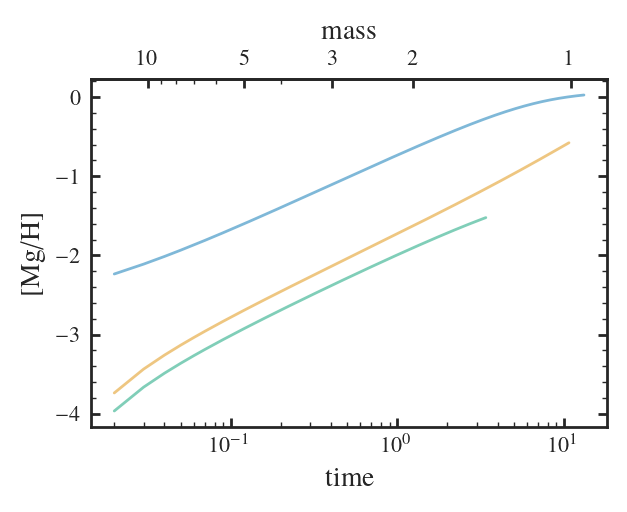

In [87]:
for model in sz_models:
    plt.plot(model.time[2:], model.MG_H[2:],  alpha=0.5)
plt.xlabel("time")
plt.xscale("log")
plt.ylabel("[Mg/H]")

ax = plt.gca()

forward = lambda x: float(vice.mlr.larson1974(x, which="age"))
reverse = lambda x: vice.mlr.larson1974(x, which="mass")
secax = ax.secondary_xaxis('top', functions=(np.vectorize(forward), np.vectorize(reverse)))
secax.set_xticks(np.array([1, 2, 3, 5, 10]),)
secax.set_xticks(np.arange(10), minor=True)
secax.set_xticklabels([1, 2, 3, 5, 10])
secax.set_xlabel(r'mass')
#secax.xaxis.minorticks_off()
ax.xaxis.set_ticks_position("bottom")


Super AGB stars (8-10 solar mass)do not even matter up to metallicity of -2 for solar or -3 for dwarf galaxies :).

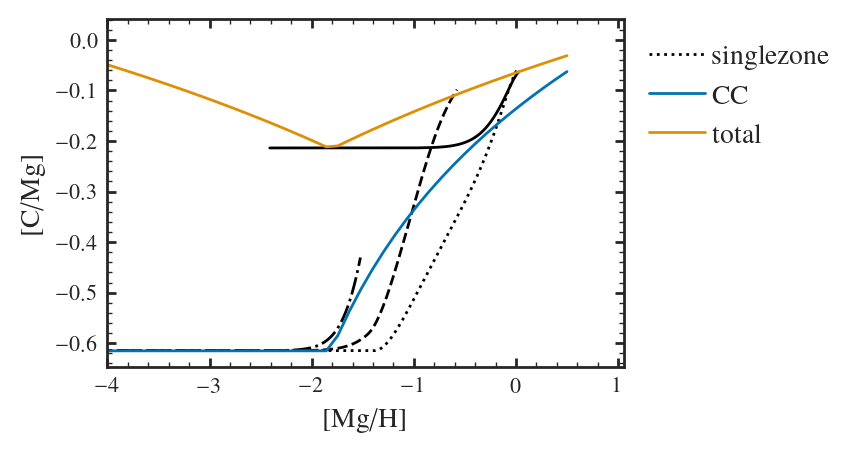

In [48]:
plot_sz(zorder=0)


plt.plot(MoverH, gcem.abund_ratio_to_brak(y_cc/yo, "c", "o"), lw=1, label="CC")
plt.plot(MoverH, gcem.abund_ratio_to_brak(y_total/yo, "c", "o"), lw=1, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
plt.xlim(-4)
arya.Legend(-1)

In [49]:
data_kwargs = dict(
    stat="median",
    label = r"low $\alpha$ subgiants",
    color=COLORS[4],
    err_kwargs=dict(facecolor=COLORS[4], alpha=0.0)
)

def cooh_subgiants(x="O_H", y="C_O", filt_ha=True, **kwargs):
    kwargs = dict(numbins=20, **kwargs)
    
    if filt_ha:
        df = surp.filter_high_alpha(subgiants)
    else:
        df = subgiants
        
    arya.medianplot(df, x=x, y=y, zorder=-2, **data_kwargs, **kwargs)

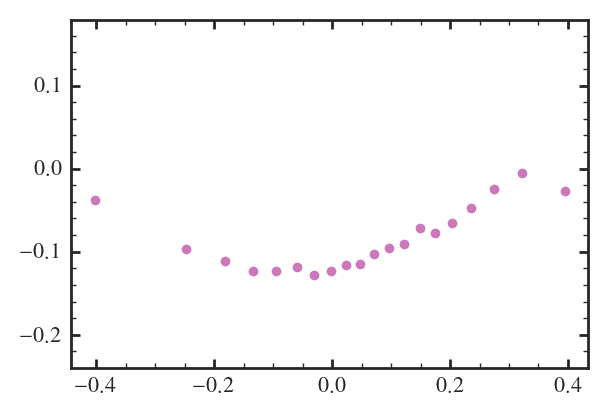

In [50]:
cooh_subgiants()

# La Finale

In [51]:
def lower_legend_label(fig):
    plt.ylabel(r"[C/O]")

    lab = plt.xlabel(r"[O/H]")
    
    leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
    box1 = leg.get_tightbbox()
    box2 = lab.get_tightbbox() 

    t1 = box1.transformed(fig.transFigure.inverted())
    t2 = box2.transformed(fig.transFigure.inverted())
    ym = (t2.y0 + t1.y1)/2


    fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


In [96]:
def plot_all_data():
    plot_sample_err(all_stars, all_star_err, marker="*", color=COLORS[8], label="MW stars")
    plot_sample_err(RL_mw, marker="p", edgecolors=COLORS[1],  color="none",label="MW HII Regions")
    plot_sample_err(CEL, CEL_err, marker="d", color=COLORS[2], label="HII Regions (CEL)")
    
    plot_sample_err(RL, marker="d", edgecolors=COLORS[2], color="none", label="HII Regions (RL)", zorder=1)

    for galaxy in RL.galaxy.unique():
        df = RL[RL.galaxy == galaxy].sort_values("O_H")
        if len(df) > 2:
            print(galaxy)
            #plt.plot(df.O_H, df.C_O, color=COLORS[2])

    plot_sample_err(high_z, high_z_err, marker="s", color=COLORS[6], label=r"high-$z$ galaxies")
    
    
    plot_sample_err(DLA, DLA_err, marker="^", color=COLORS[3], label=r"damped Lyman$\alpha$ systems")


    cooh_subgiants()

M101
NGC 300
M33
LMC
SMC
NGC 2403


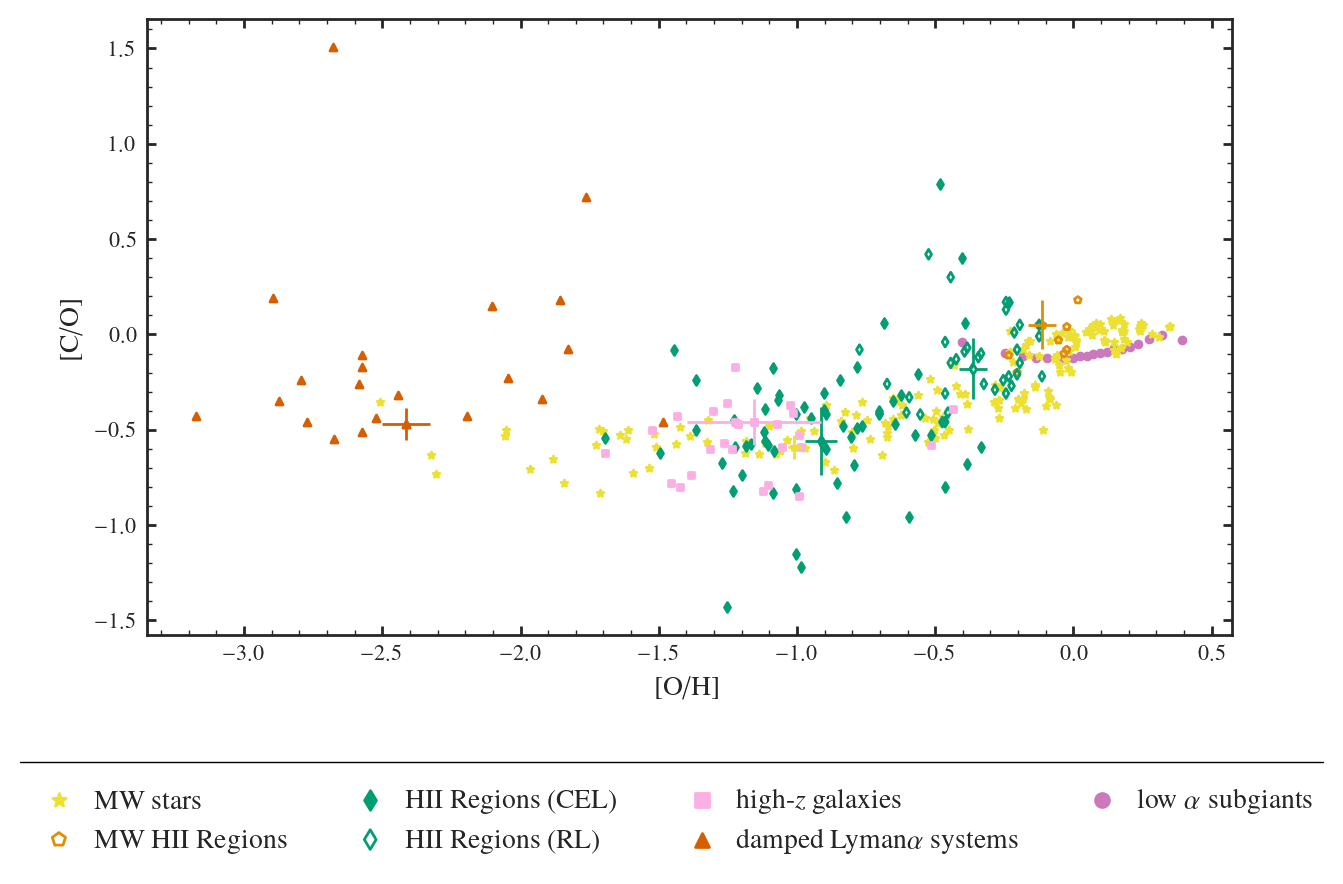

In [97]:
fig = plt.figure(figsize=(7, 4))
plot_all_data()

lower_legend_label(fig)


M101
NGC 300
M33
LMC
SMC
NGC 2403


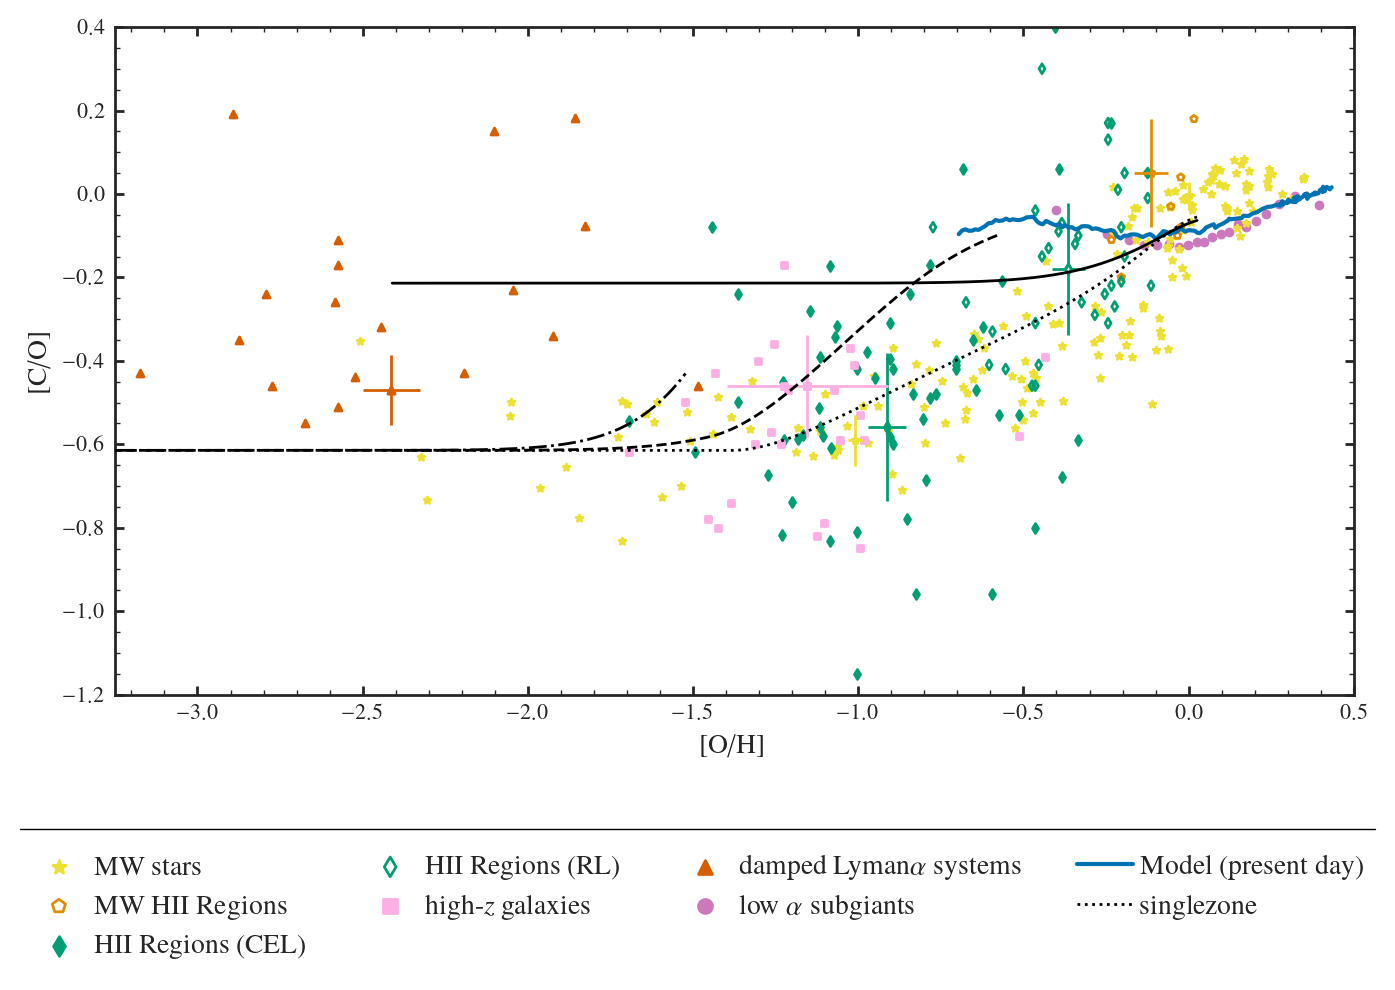

In [98]:
fig = plt.figure(figsize=(7, 4))

plot_all_data()
plot_fiducial()
plot_sz()

lower_legend_label(fig)
plt.xlim(-3.25, 0.5)
plt.ylim(-1.2, 0.4)
plt.tight_layout()


plt.savefig("figures/summary.pdf")

# Low z mean

In [55]:
all_data = pd.concat([
    RL_mw,
    RL,
    DLA, 
    all_stars,
    high_z,
    CEL,
])

In [56]:
w = 1 / all_data.C_O_err**2

filt = all_data.O_H < -1
filt &= all_data.O_H > -1.8

w  = w[filt]
x = all_data.C_O[filt]

In [57]:
μ = np.sum(x*w) / np.sum(w)
σ = 1/np.sqrt(np.sum(w))

μ, σ

(np.float64(-0.561571797377381), np.float64(0.0064298141993756755))

In [58]:
surp.gce_math.brak_to_abund_ratio(-0.62, "c", "mg") * vice.yields.ccsne.settings["mg"] / 1e-4

np.float64(7.90177708532101)

In [59]:
surp.gce_math.brak_to_abund_ratio(-0.62, "c", "mg") * vice.yields.ccsne.settings["mg"] * σ*np.log(10)/ 1e-4

np.float64(0.1169873452705224)

In [60]:
vice.yields.ccsne.settings["mg"] * 10**-0.62 

0.00015640390632007078

In [61]:
import weighted

In [62]:
weighted.quantile(x, w, 0.16)

np.float64(-0.6270754917646925)

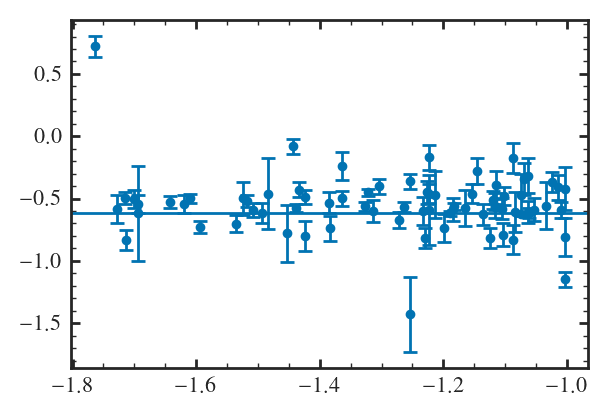

In [63]:
plt.errorbar(all_data.O_H[filt], all_data.C_O[filt], yerr = 1/w**0.5, fmt="o")
plt.axhline(-0.62)